### Q: Can we get the CNNs to overfit to the data?

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from netam import framework, models
from netam.common import nt_mask_tensor_of, BASES
from netam.framework import (
    SHMoofDataset,
    RSSHMBurrito,
    trimmed_shm_model_outputs_of_crepe,
)
from epam.torch_common import pick_device

from epam import sequences, evaluation
from epam.molevol import reshape_for_codons, build_mutation_matrices, codon_probs_of_mutation_matrices

from shmex.shm_data import load_shmoof_dataframes, dataset_dict
from shmex import shm_zoo
from shmex.shm_eval import ragged_np_pcp_encoding, oe_plot_of

Using Metal Performance Shaders


In [2]:
import io
from IPython.display import Image, display

def show_figure(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)

    # Display the figure from the buffer
    display(Image(data=buf.read()))

    # Close the buffer
    buf.close()

We're just going to use shmoof training data, the same data used to train the context NT model.

In [3]:
device = pick_device()

site_count = 500
train_df, val_df = load_shmoof_dataframes(dataset_dict["shmoof"], val_nickname="small")
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
pcp_df = train_df
subsampled_train_df = train_df.iloc[::int(len(train_df)/5000)].copy().reset_index(drop=True)

train_data_5mer = SHMoofDataset(train_df, kmer_length=5, site_count=site_count)
val_data_5mer = SHMoofDataset(val_df, kmer_length=5, site_count=site_count)

train_data_3mer = SHMoofDataset(train_df, kmer_length=3, site_count=site_count)
val_data_3mer = SHMoofDataset(val_df, kmer_length=3, site_count=site_count)

for data in [train_data_5mer, val_data_5mer, train_data_3mer, val_data_3mer]:
    data.to(device)

Using Metal Performance Shaders


In [4]:
def oe_plot_of_crepe(crepe, pcp_df, title):
    crepe.to("cpu")
    ratess, cspss = trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])
    site_count = crepe.encoder.site_count
    mut_indicators, base_idxss, masks = ragged_np_pcp_encoding(pcp_df["parent"], pcp_df["child"], site_count)
    fig, oe_results = oe_plot_of(ratess, masks, pcp_df["branch_length"], mut_indicators, title)
    oe_results.pop("counts_twinx_ax")
    return fig, oe_results


In [ ]:
fivemer_model = shm_zoo.create_model("fivemer")
fivemer_model.to(device)
fivemer_burrito = RSSHMBurrito(train_data_5mer, val_data_5mer, fivemer_model, name="fivemer")
fivemer_loss_history = fivemer_burrito.train(epochs=100)
fivemer_burrito.save_crepe("trained_models/fivemer")
fivemer_crepe = fivemer_burrito.to_crepe()
fivemer_loss_history

In [14]:
fivemer_crepe = framework.load_crepe("trained_models/fivemer")

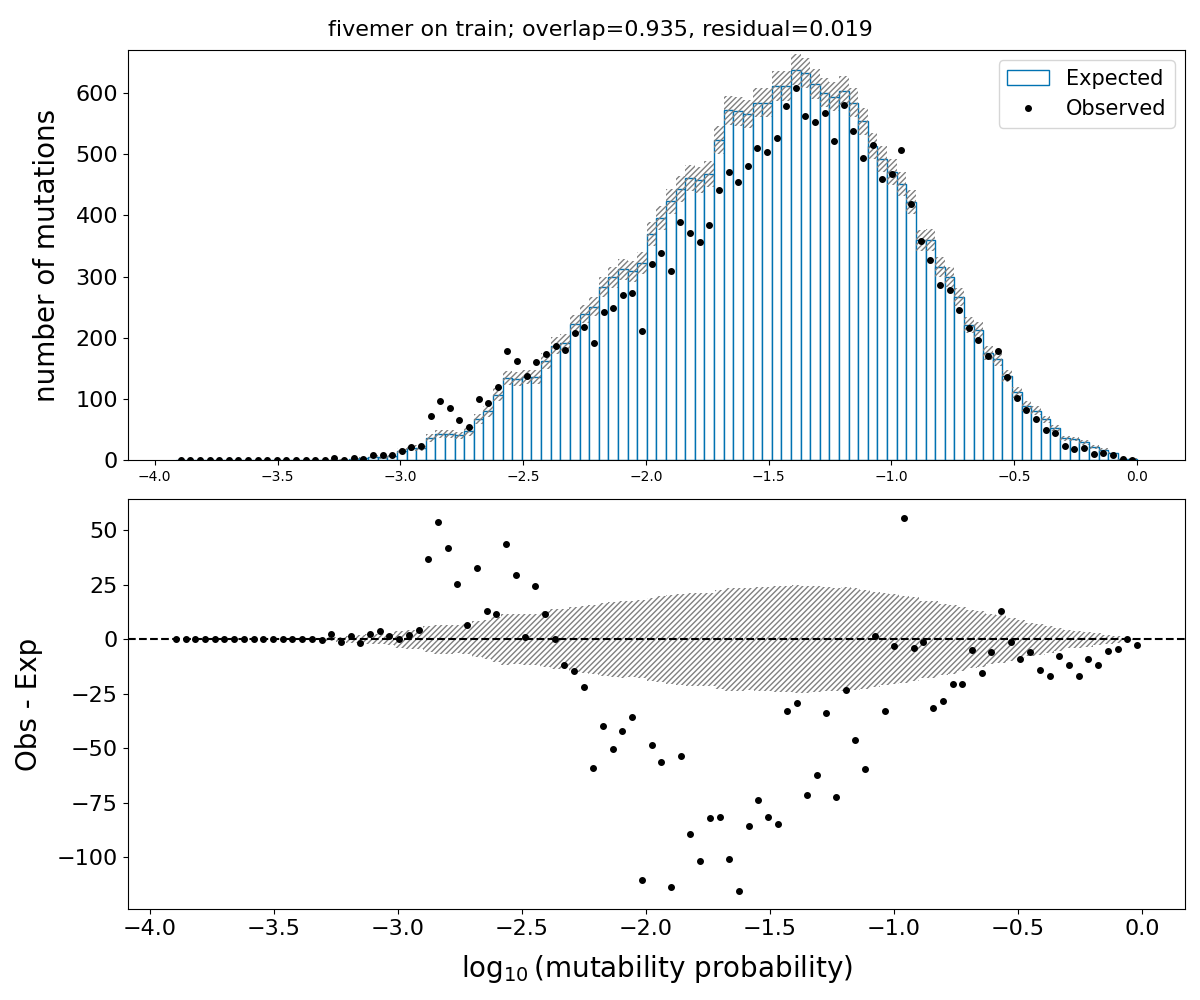

In [15]:
show_figure(oe_plot_of_crepe(fivemer_crepe, subsampled_train_df, "fivemer on train")[0])

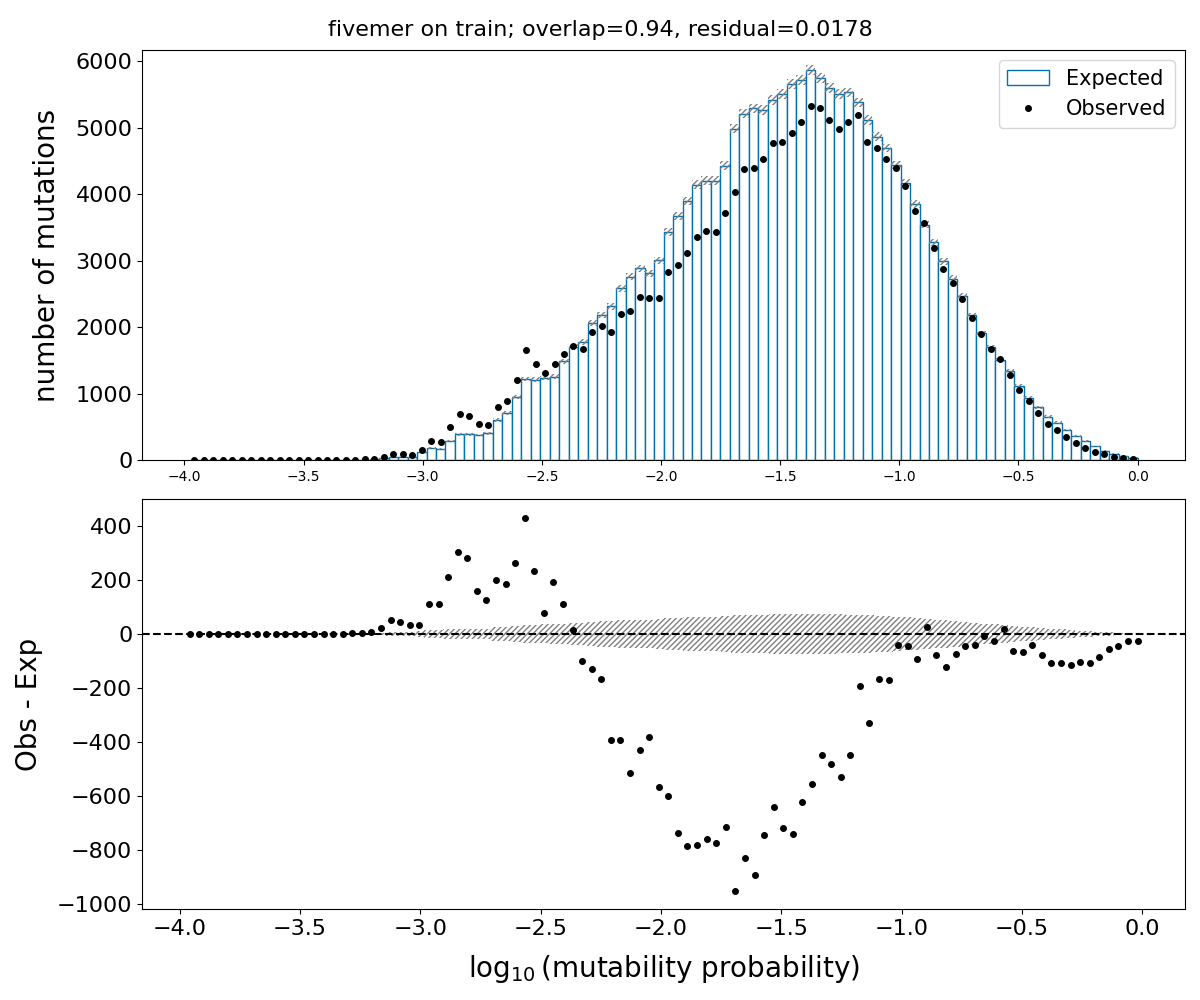

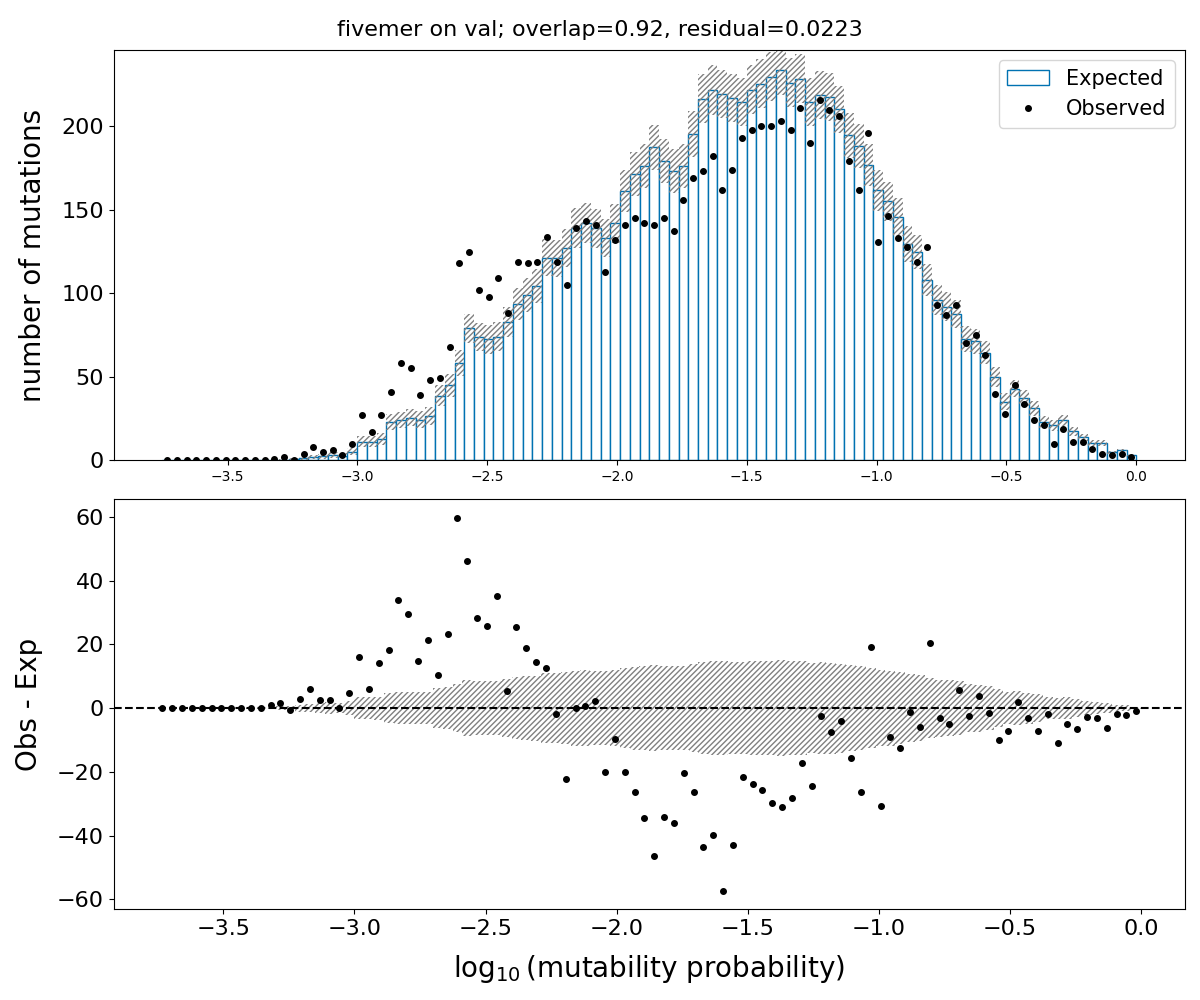

In [9]:
show_figure(oe_plot_of_crepe(fivemer_crepe, train_df, "fivemer on train")[0])
show_figure(oe_plot_of_crepe(fivemer_crepe, val_df, "fivemer on val")[0])

In [6]:
big_cnn_model = shm_zoo.create_model("cnn_ind_lrg")
big_cnn_model.to(device)
cnn_burrito = RSSHMBurrito(train_data_3mer, val_data_3mer, big_cnn_model, name="cnn_ind_lrg")
cnn_loss_history = cnn_burrito.train(epochs=100)
cnn_burrito.save_crepe("trained_models/cnn_ind_lrg")
cnn_crepe = cnn_burrito.to_crepe()
cnn_loss_history

Epoch: 100%|██████████| 100/100 [27:36<00:00, 16.56s/it, loss_diff=2.823e-05, lr=0.00625, val_loss=0.06529]


,train_loss,val_loss
0,0.077082,0.069133
1,0.081393,0.074039
2,0.079291,0.069334
3,0.076056,0.067359
4,0.075038,0.066975
...,...,...
96,0.070958,0.065241
97,0.070939,0.065303
98,0.070937,0.065305
99,0.070956,0.065266


In [9]:
cnn_crepe = framework.load_crepe("trained_models/cnn_ind_lrg")

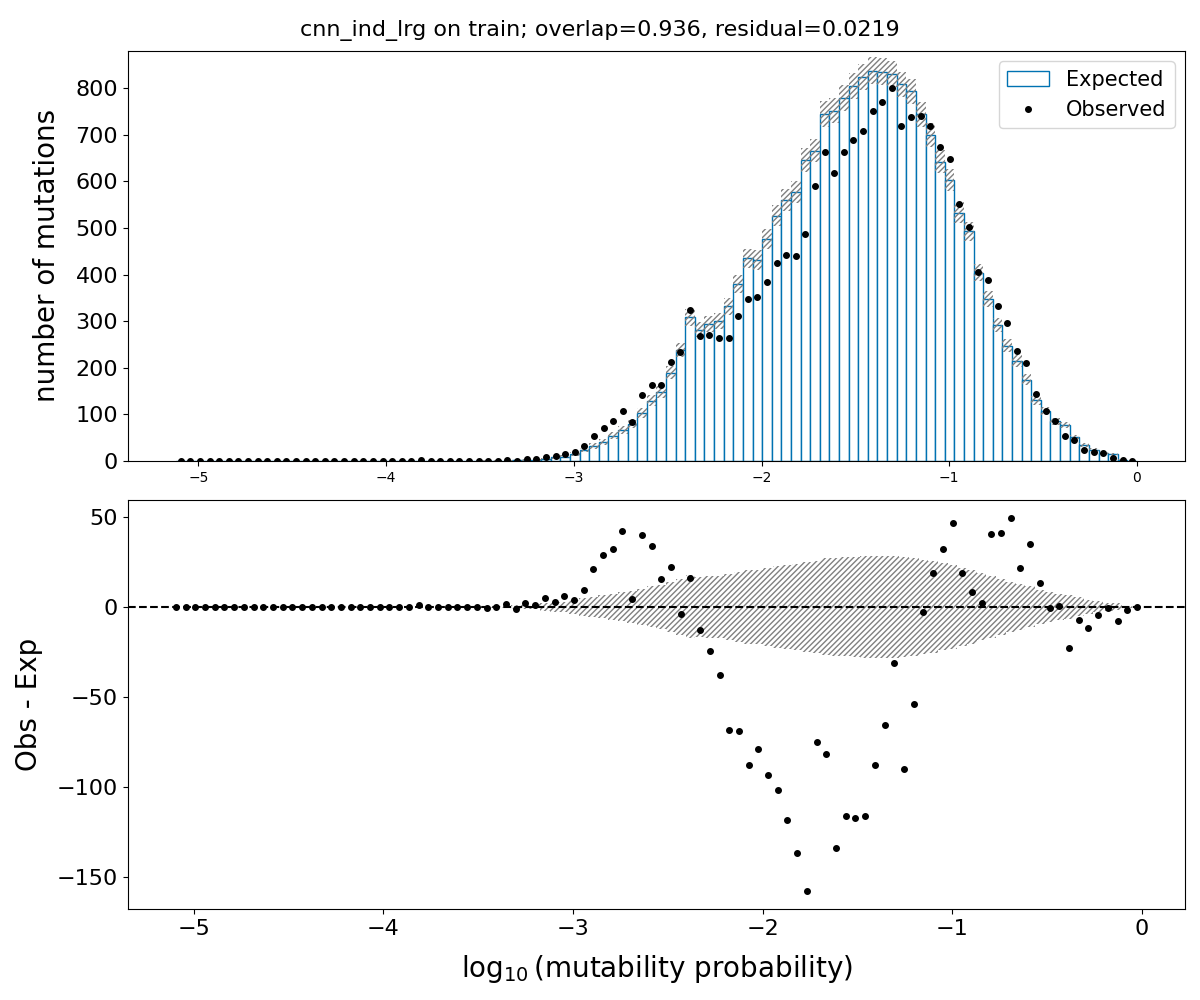

In [10]:
show_figure(oe_plot_of_crepe(cnn_crepe, subsampled_train_df, "cnn_ind_lrg on train")[0])

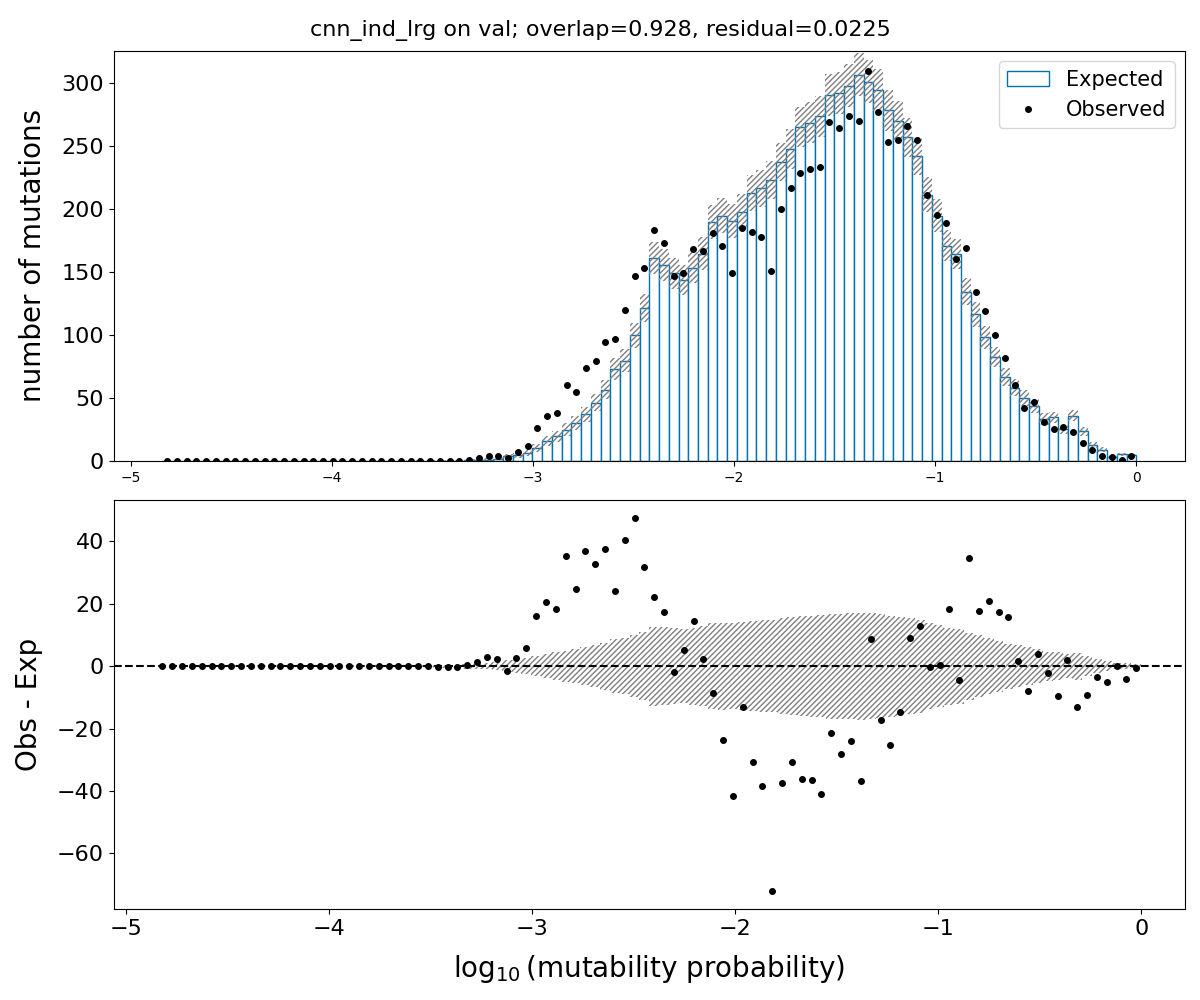

In [7]:
show_figure(oe_plot_of_crepe(cnn_crepe, val_df, "cnn_ind_lrg on val")[0])

In [ ]:
from shmex.shm_eval import ragged_np_pcp_encoding, trimmed_shm_model_outputs_of_crepe

site_count = 500

mut_indicators, base_idxss, masks = ragged_np_pcp_encoding(pcp_df["parent"], pcp_df["child"], site_count)

ratess, cspss = trimmed_shm_model_outputs_of_crepe(crepe, pcp_df["parent"])

Using Metal Performance Shaders


(<Figure size 1200x1000 with 2 Axes>,
 {'overlap': 0.9292869579970533,
  'residual': 0.0205257589678285,
  'counts_twinx_ax': None})

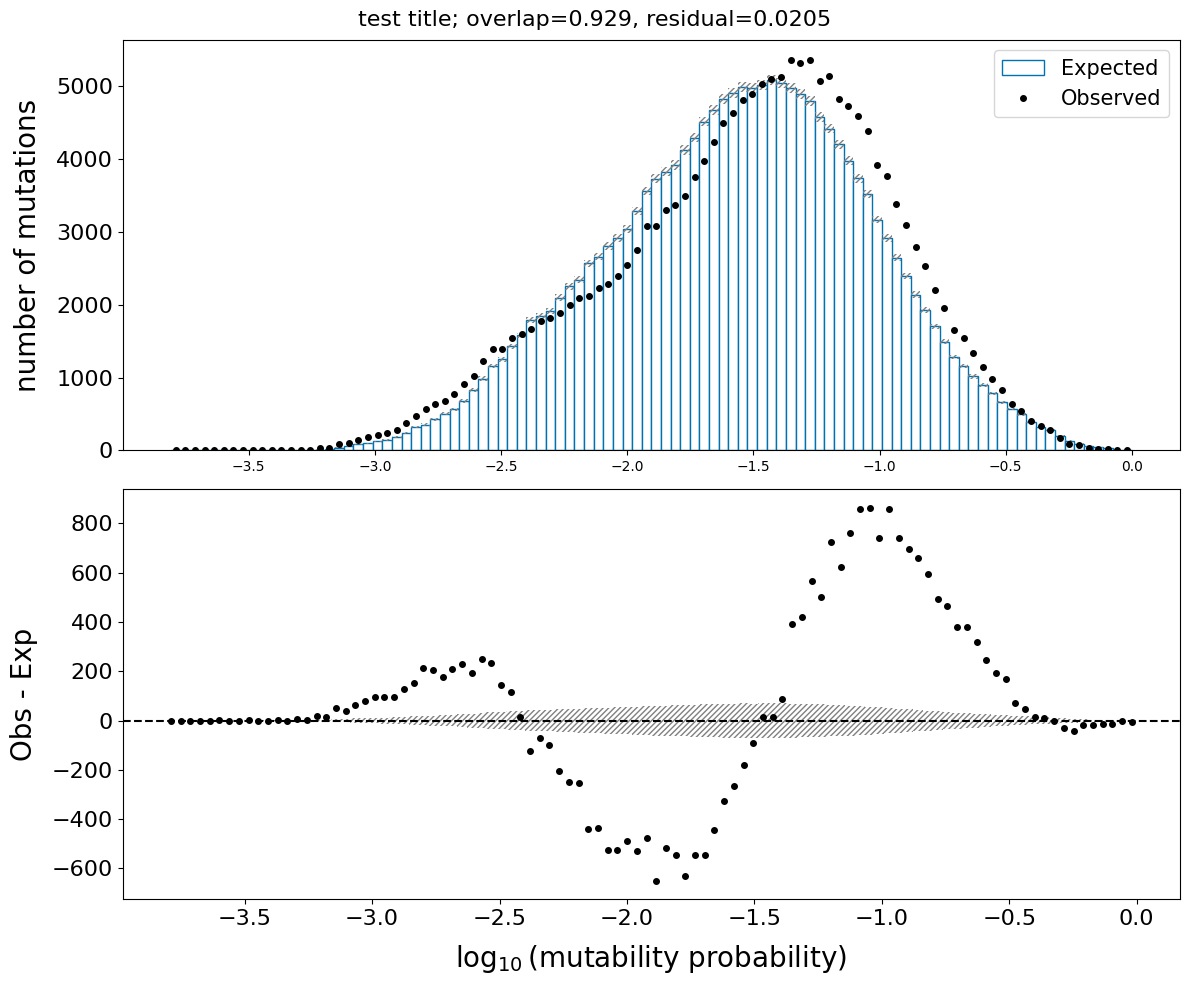

In [ ]:
def oe_plot_of(ratess, masks, branch_lengths, mut_indicators, suptitle_prefix=""):
    mut_probs_l = []
    mut_indicators_l = []

    for rates, mask, branch_length, mut_indicator in zip(ratess, masks, branch_lengths, mut_indicators):
        mut_probs = 1.0 - torch.exp(-rates * branch_length)
        mut_probs_l.append(mut_probs[mask])
        mut_indicators_l.append(mut_indicator[mask])

    oe_plot_df = pd.DataFrame({
        "prob": torch.cat(mut_probs_l).numpy(),
        "mutation": np.concatenate(mut_indicators_l),
    })

    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    result_dict = evaluation.plot_observed_vs_expected(oe_plot_df, None, axs[0], axs[1])
    if suptitle_prefix != "":
        suptitle_prefix = suptitle_prefix + "; "
    fig.suptitle(f"{suptitle_prefix}overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}", fontsize=16)
    plt.tight_layout()

    return fig, result_dict

oe_plot_of(ratess, masks, pcp_df["branch_length"], mut_indicators, "test title")

In [ ]:
# make sure old_df["mutation"] is the same as oe_plot_df_alt["mutation"]
# assert (old_df["mutation"] == oe_plot_df_alt["mutation"]).all()
pcp_df.loc[0,"rates"][70:90]

tensor([0.2887, 0.7860, 0.5851, 0.3639, 0.5662, 0.9502, 1.0953, 1.6952, 1.1862,
        1.7726, 1.1611, 1.4580, 1.5345, 0.5531, 1.2257, 0.5662, 0.5500, 1.0199,
        3.0074, 2.8827])

In [ ]:
ratess[0][70:90]

tensor([0.2887, 0.7860, 0.5851, 0.3639, 0.5662, 0.9502, 1.0953, 1.6952, 1.1862,
        1.7726, 1.1611, 1.4580, 1.5345, 0.5531, 1.2257, 0.5662, 0.5500, 1.0199,
        3.0074, 2.8827])

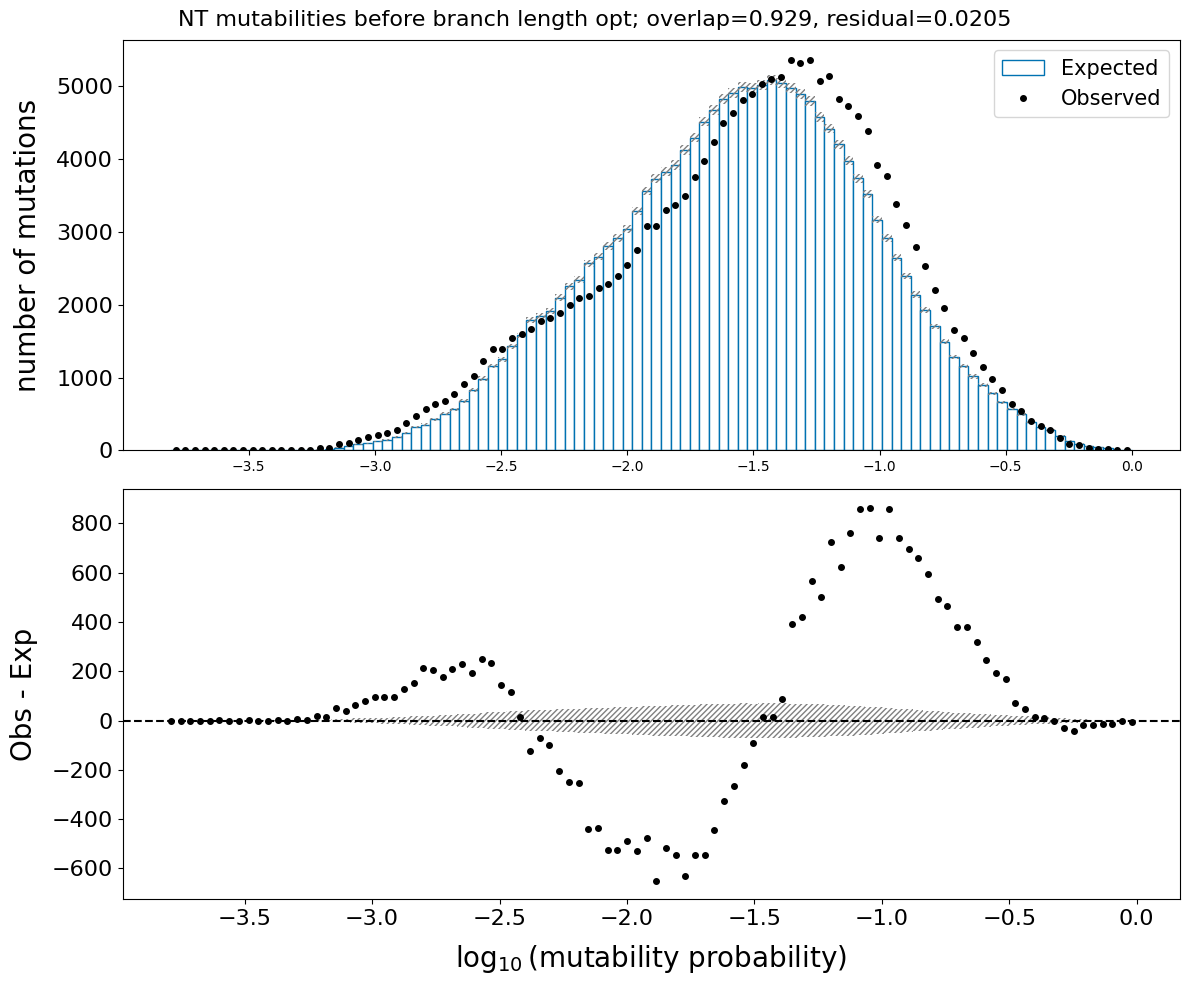

In [ ]:
def nt_level_oe_plot_df_of_pcp_df(pcp_df):
   pcp_df["mutation_indicator"] = None
   pcp_df["new_base_idxs"] = None
   pcp_df["mut_probs"] = None
   for i, row in pcp_df.iterrows():
      parent = row['parent']
      child = row['child']
      rates = row['rates']
      branch_length = row['branch_length']
      subs_probs = row['subs_probs']
      branch_length = row['branch_length']
      scaled_rates = rates * branch_length
      mut_probs = 1.0 - torch.exp(-scaled_rates)
      mut_indicator, new_base_idxs = framework.encode_mut_pos_and_base(parent, child)
      mask = nt_mask_tensor_of(child)
      pcp_df.at[i, "mut_probs"] = mut_probs[mask]
      pcp_df.at[i, "mutation_indicator"] = mut_indicator[mask]
      pcp_df.at[i, "new_base_idxs"] = new_base_idxs[mask]

   all_mut_probs = torch.cat(pcp_df["mut_probs"].tolist())
   all_mut_indicators = torch.cat(pcp_df["mutation_indicator"].tolist())
   all_new_base_idxs = torch.cat(pcp_df["new_base_idxs"].tolist())
   
   oe_plot_df = pd.DataFrame({"prob": all_mut_probs, "mutation": all_mut_indicators})
   return oe_plot_df

def nt_level_oe_plot_of_pcp_df(pcp_df, description):
   oe_plot_df = nt_level_oe_plot_df_of_pcp_df(pcp_df)
   assert oe_plot_df["prob"].min() > 0
   fig, axs = plt.subplots(2, 1, figsize=(12, 10))
   result_dict = evaluation.plot_observed_vs_expected(oe_plot_df, None, axs[0], axs[1])
   fig.suptitle(f"{description}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}", fontsize=16)
   plt.tight_layout()

nt_level_oe_plot_of_pcp_df(pcp_df, "NT mutabilities before branch length opt")

In [ ]:
def optimize_site_indep_branch_length(pcp_df):
    burrito = framework.RSSHMBurrito(
            None,
            framework.SHMoofDataset(pcp_df, kmer_length=model.kmer_length, site_count=site_count),
            model,
        )
    burrito.standardize_and_optimize_branch_lengths()

    pcp_df["orig_branch_length"] = pcp_df["branch_length"]
    pcp_df["branch_length"] = burrito.val_loader.dataset.branch_lengths
    return pcp_df

pcp_df = optimize_site_indep_branch_length(pcp_df)

Finding optimal branch lengths: 100%|██████████| 46386/46386 [02:26<00:00, 316.50it/s]


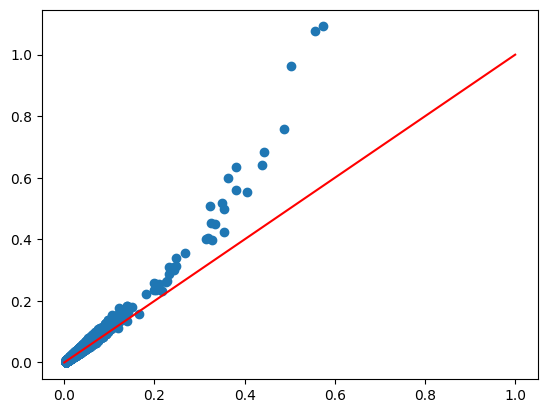

In [ ]:
plt.scatter(pcp_df["orig_branch_length"], pcp_df["branch_length"])
# add a y=x line
plt.plot([0, 1], [0, 1], color="red")

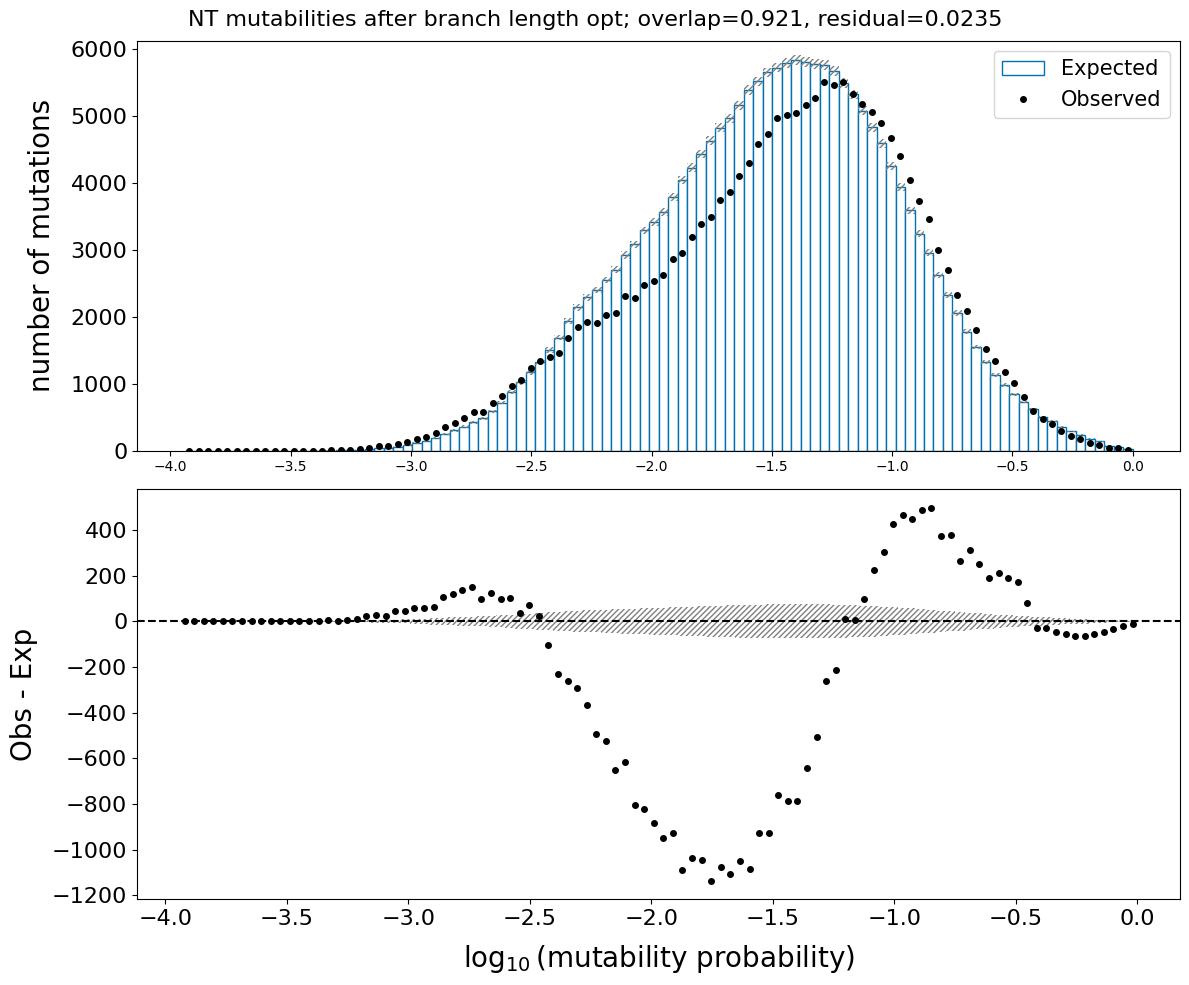

In [ ]:
nt_level_oe_plot_of_pcp_df(pcp_df, "NT mutabilities after branch length opt")

#### Now let's move on to the codon-level process

In [ ]:
def codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, sub_probs):
    """
    Compute the probabilities of mutating to various codons for a parent sequence. 
    
    This uses the same machinery as we use for fitting the DNSM, but we stay on
    the codon level rather than moving to syn/nonsyn changes.
    """
    # This is from `aaprobs_of_parent_scaled_rates_and_sub_probs`:
    mut_probs = 1.0 - torch.exp(-scaled_rates)
    parent_codon_idxs = reshape_for_codons(parent_idxs)
    codon_mut_probs = reshape_for_codons(mut_probs)
    codon_sub_probs = reshape_for_codons(sub_probs)
    
    # This is from `aaprob_of_mut_and_sub`:
    mut_matrices = build_mutation_matrices(parent_codon_idxs, codon_mut_probs, codon_sub_probs)
    codon_probs = codon_probs_of_mutation_matrices(mut_matrices)

    return codon_probs

The following sets us up to work with "hit classes", which are the number of differences within a codon as described above. That is, we're calculating the probability of $x$ mutations within a codon given the model.

In [ ]:
# This block just sets up `hit_class_tensors`, a dictionary of tensors that we can use to compute the number of differences between codons, as well as `codon_to_idxs` which maps codons to their indices in the tensors.

# Function to calculate the number of differences between two codons
def hit_class(codon1, codon2):
    return sum(c1 != c2 for c1, c2 in zip(codon1, codon2))

# Initialize a dictionary to store hit_class_tensors indexed by codons
hit_class_tensors = {}

# Iterate over all possible codons and calculate the hit_class_tensors
for i, base1 in enumerate(BASES):
    for j, base2 in enumerate(BASES):
        for k, base3 in enumerate(BASES):
            codon = base1 + base2 + base3
            hit_class_tensor = torch.zeros(4, 4, 4, dtype=torch.int)
            for i2, base1_2 in enumerate(BASES):
                for j2, base2_2 in enumerate(BASES):
                    for k2, base3_2 in enumerate(BASES):
                        codon_2 = base1_2 + base2_2 + base3_2
                        hit_class_tensor[i2, j2, k2] = hit_class(codon, codon_2)
            hit_class_tensors[codon] = hit_class_tensor

# make a dict mapping from codon to triple integer index
codon_to_idxs = {base_1+base_2+base_3: (i, j, k) for i, base_1 in enumerate(BASES) for j, base_2 in enumerate(BASES) for k, base_3 in enumerate(BASES)}
codon_to_idxs

ctc_hit_class_tensor = hit_class_tensors["CTC"]
assert ctc_hit_class_tensor[codon_to_idxs["CTC"]] == 0
assert ctc_hit_class_tensor[codon_to_idxs["ATC"]] == 1
assert ctc_hit_class_tensor[codon_to_idxs["ACC"]] == 2
assert ctc_hit_class_tensor[codon_to_idxs["ACT"]] == 3

In [ ]:
def hit_class_probs(hit_class_tensor, codon_probs):
    """
    Calculate total probabilities for each number of differences between codons.

    Args:
    - hit_class_tensor (torch.Tensor): A 4x4x4 integer tensor containing the number of differences
                                       between each codon and a reference codon.
    - codon_probs (torch.Tensor): A 4x4x4 tensor containing the probabilities of various codons.

    Returns:
    - total_probs (torch.Tensor): A 1D tensor containing the total probabilities for each number
                                   of differences (0 to 3).
    """
    total_probs = []

    for hit_class in range(4):
        # Create a mask of codons with the desired number of differences
        mask = hit_class_tensor == hit_class

        # Multiply componentwise with the codon_probs tensor and sum
        total_prob = (codon_probs * mask.float()).sum()

        # Append the total probability to the list
        total_probs.append(total_prob.item())

    return torch.tensor(total_probs)

def hit_class_probs_seq(parent_seq, codon_probs, hit_class_tensors):
    """
    Calculate probabilities of hit classes between parent codons and all other codons for all the sites of a sequence.

    Args:
    - parent_seq (str): The parent nucleotide sequence.
    - codon_probs (torch.Tensor): A tensor containing the probabilities of various codons.
    - hit_class_tensors (dict): A dictionary containing hit_class_tensors indexed by codons.

    Returns:
    - probs (torch.Tensor): A tensor containing the probabilities of different
                            counts of hit classes between parent codons and
                            all other codons.
    """
    # Check if the size of the first dimension of codon_probs matches the length of parent_seq divided by 3
    if len(parent_seq) // 3 != codon_probs.size(0):
        raise ValueError("The size of the first dimension of codon_probs should match the length of parent_seq divided by 3.")

    # Initialize a list to store the probabilities of different counts of differences
    probs = []

    # Iterate through codons in parent_seq
    for i in range(0, len(parent_seq), 3):
        # Extract the codon from parent_seq
        codon = parent_seq[i:i+3]

        # if codon contains an N, append a tensor of 4 -1s to probs then continue
        if "N" in codon:
            probs.append(torch.tensor([-100.0] * 4))
            continue

        # Get the corresponding hit_class_tensor from hit_class_tensors
        hit_class_tensor = hit_class_tensors[codon]

        # Get the ith entry of codon_probs
        codon_probs_i = codon_probs[i // 3]

        # Calculate the probabilities of different counts of differences using the hit_class_tensor and codon_probs_i
        total_probs = hit_class_probs(hit_class_tensor, codon_probs_i)

        # Append the probabilities to the list
        probs.append(total_probs)

    # Concatenate all the probabilities into a tensor
    probs = torch.stack(probs)

    return probs


Now we need to prepare dataframes for the codon-level OE plot.

In [ ]:
# This block just shows how things are going to go for a single parent sequence.

parent, rates, subs_probs, branch_length = pcp_df.loc[0, ["parent", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[9.8619e-01, 1.3751e-02, 5.6260e-05, 6.6442e-08],
        [9.8142e-01, 1.8466e-02, 1.1320e-04, 2.2477e-07],
        [9.8800e-01, 1.1960e-02, 3.7381e-05, 2.5892e-08],
        [9.8956e-01, 1.0405e-02, 3.5501e-05, 3.9578e-08],
        [9.9297e-01, 7.0107e-03, 1.5740e-05, 1.1243e-08],
        [9.8532e-01, 1.4649e-02, 3.4596e-05, 1.9677e-08]])

In [ ]:
def hit_classes_of_pcp_df(pcp_df, codon_count):
    labels = torch.zeros((len(pcp_df), codon_count), dtype=torch.int64)

    for index, row in pcp_df.iterrows():
        parent_seq = row['parent']
        child_seq = row['child']

        assert len(parent_seq) == len(child_seq)
        valid_length = (len(parent_seq) // 3) * 3
        
        # Check and warn if the valid codon count exceeds the codon_count parameter
        if valid_length // 3 > codon_count:
            print(f"Warning: Truncating sequences at index {index} to {codon_count} codons, though {valid_length // 3} could be processed.")

        # Chunk into codons and count mutations
        num_mutations = []
        for i in range(0, valid_length, 3):
            parent_codon = parent_seq[i:i+3]
            child_codon = child_seq[i:i+3]
            
            if 'N' in parent_codon or 'N' in child_codon:
                num_mutations.append(-100)
            else:
                # Count differing bases
                mutations = sum(1 for p, c in zip(parent_codon, child_codon) if p != c)
                num_mutations.append(mutations)
        
        # Pad or truncate the mutation counts to match codon_count
        padded_mutations = num_mutations[:codon_count]  # Truncate if necessary
        padded_mutations += [-100] * (codon_count - len(padded_mutations))  # Pad with -1s
        
        # Update the labels tensor for this row
        labels[index] = torch.tensor(padded_mutations, dtype=torch.int)

    return labels

# Example usage
data = {
    'parent': ['ATGCGTACGTAG', 'GTCGATCGATCG'],
    'child':  ['ATGCGTAGGTAN', 'GTCGATCGTTGA']
}
example_df = pd.DataFrame(data)
example_hit_classes = hit_classes_of_pcp_df(example_df, 4)
example_hit_classes


tensor([[   0,    0,    1, -100],
        [   0,    0,    1,    2]])

In [ ]:
def branch_length_quantile_dict_of_pcp_df(pcp_df):
    """
    Maps from the index of a row in pcp_df to the quantile of its branch length.
    """
    branch_length_quantile = pd.qcut(pcp_df["branch_length"], q=4, labels=False)
    branch_length_quantile_dict = branch_length_quantile.to_dict()
    return branch_length_quantile_dict

branch_length_quantile_dict = branch_length_quantile_dict_of_pcp_df(pcp_df)

In [ ]:
def hit_class_probs_of_pcp_df(pcp_df, hit_class_tensors):
    all_hc_probs_l = []

    for _, row in tqdm(pcp_df.iterrows(), total=len(pcp_df), desc="Computing hit class probs"):
        parent = row['parent']
        rates = row['rates']
        subs_probs = row['subs_probs']
        branch_length = row['branch_length']

        parent = parent[:len(parent) - len(parent) % 3]
        rates = rates[:len(rates) - len(rates) % 3]
        subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

        parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
        scaled_rates = branch_length * rates

        codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)

        hc_probs = hit_class_probs_seq(parent, codon_probs, hit_class_tensors)
        all_hc_probs_l.append(hc_probs)

    return all_hc_probs_l

def hc_site_df_of_pcp_df(pcp_df, hit_class_tensors):
    """
    Make a df of hit class probabilities and observations at each site in each sequence.
    """
    all_hc_probs_l = hit_class_probs_of_pcp_df(pcp_df, hit_class_tensors)
    observed_hcs = hit_classes_of_pcp_df(pcp_df, site_count//3)
    assert len(observed_hcs) == len(pcp_df)

    df_rows = []
    for seq_idx, (observed_hc_row, hc_probs_row) in enumerate(zip(tqdm(observed_hcs, desc="Consolidating rows"), all_hc_probs_l)):
        for site_idx, (observed_hc, diff_prob_vect) in enumerate(zip(observed_hc_row, hc_probs_row[:len(observed_hc_row)])):
            if observed_hc >= 0: # filtering out N-containing codons
                v = tuple(diff_prob_vect.detach().numpy())
                df_rows.append((seq_idx, site_idx, observed_hc.item()) + v)
        
    hc_site_df = pd.DataFrame(df_rows, columns=["sequence", "site", "hit_class", "0_hc_prob", "1_hc_prob", "2_hc_prob", "3_hc_prob"])
    hc_site_df["branch_length_quantile"] = hc_site_df["sequence"].map(branch_length_quantile_dict)

    return hc_site_df

hc_site_df = hc_site_df_of_pcp_df(pcp_df, hit_class_tensors)
hc_site_df

Consolidating rows: 100%|██████████| 46386/46386 [00:23<00:00, 1954.84it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,22,0,0.970040,0.029757,0.000203,3.754987e-07,2
1,0,23,0,0.986942,0.013007,0.000051,6.162942e-08,2
2,0,24,0,0.985998,0.013939,0.000062,8.945300e-08,2
3,0,25,0,0.965006,0.034594,0.000399,1.455735e-06,2
4,0,26,0,0.964632,0.034955,0.000412,1.575996e-06,2
...,...,...,...,...,...,...,...,...
4346600,46385,113,0,0.977571,0.022261,0.000167,4.163669e-07,2
4346601,46385,114,0,0.968105,0.031579,0.000315,8.792341e-07,2
4346602,46385,115,0,0.975042,0.024756,0.000201,5.307541e-07,2
4346603,46385,116,0,0.983047,0.016862,0.000091,1.484213e-07,2


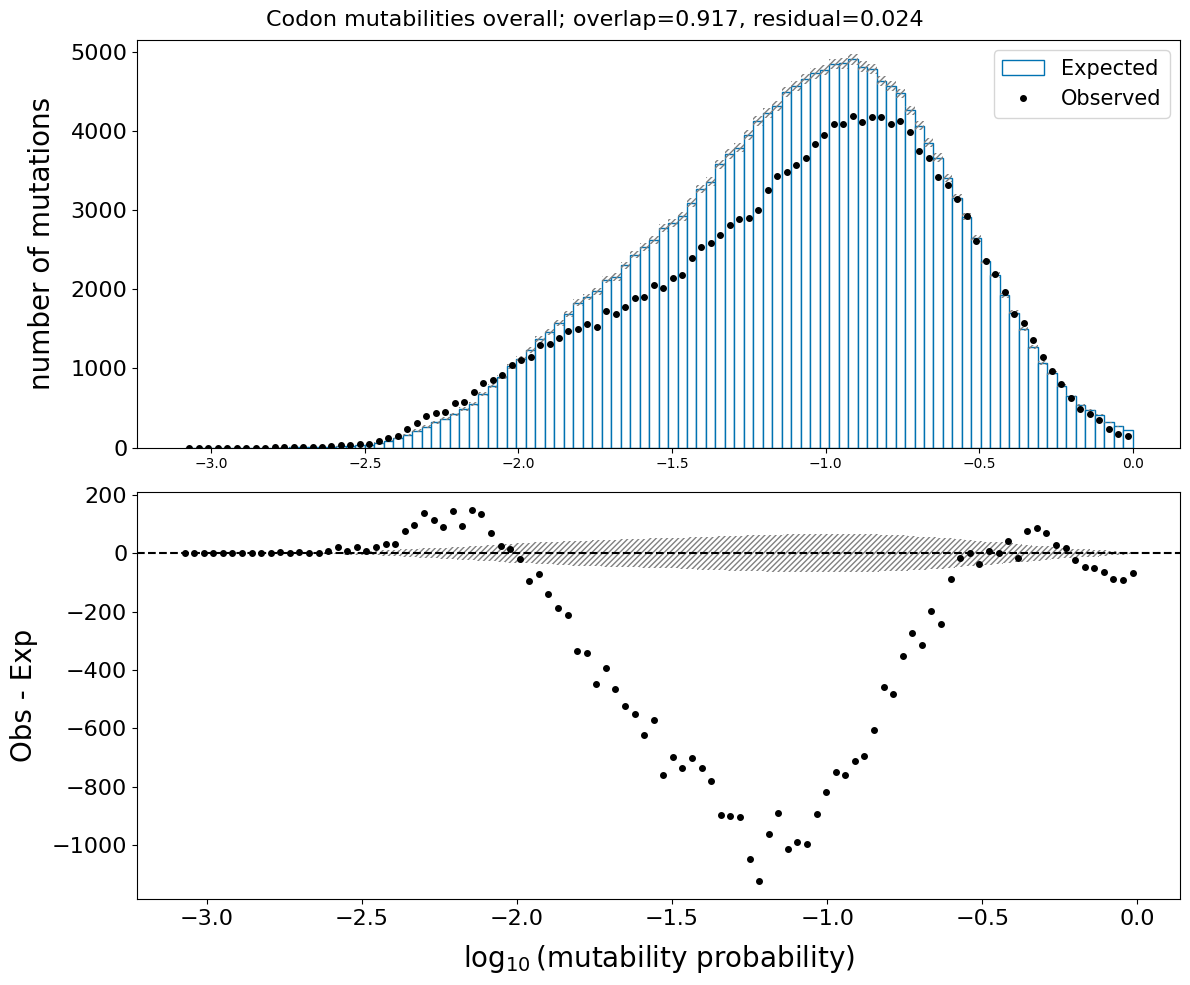

In [ ]:
def simple_codon_oe_plot(hc_site_df, description):
    """
    No partitioning by mutation class.
    """
    plot_df = pd.DataFrame({
        "mutation": hc_site_df["hit_class"] > 0,
        "prob": 1 - hc_site_df["0_hc_prob"],
    })
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs[0], axs[1])
    fig.suptitle(f"{description}; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}", fontsize=16)    
    fig.tight_layout()
    return fig, result_dict

fig, result_dict = simple_codon_oe_plot(hc_site_df, "Codon mutabilities overall")

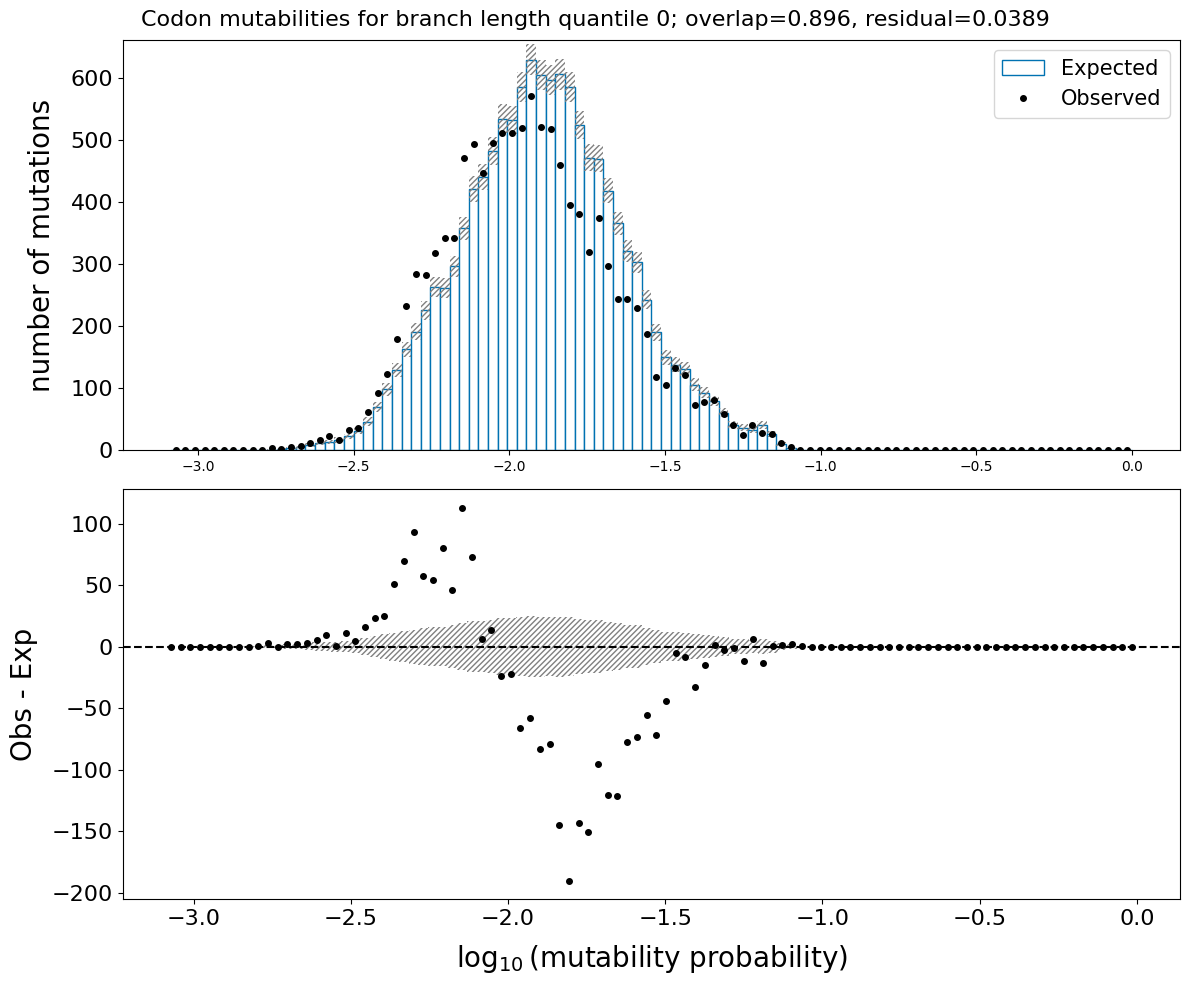

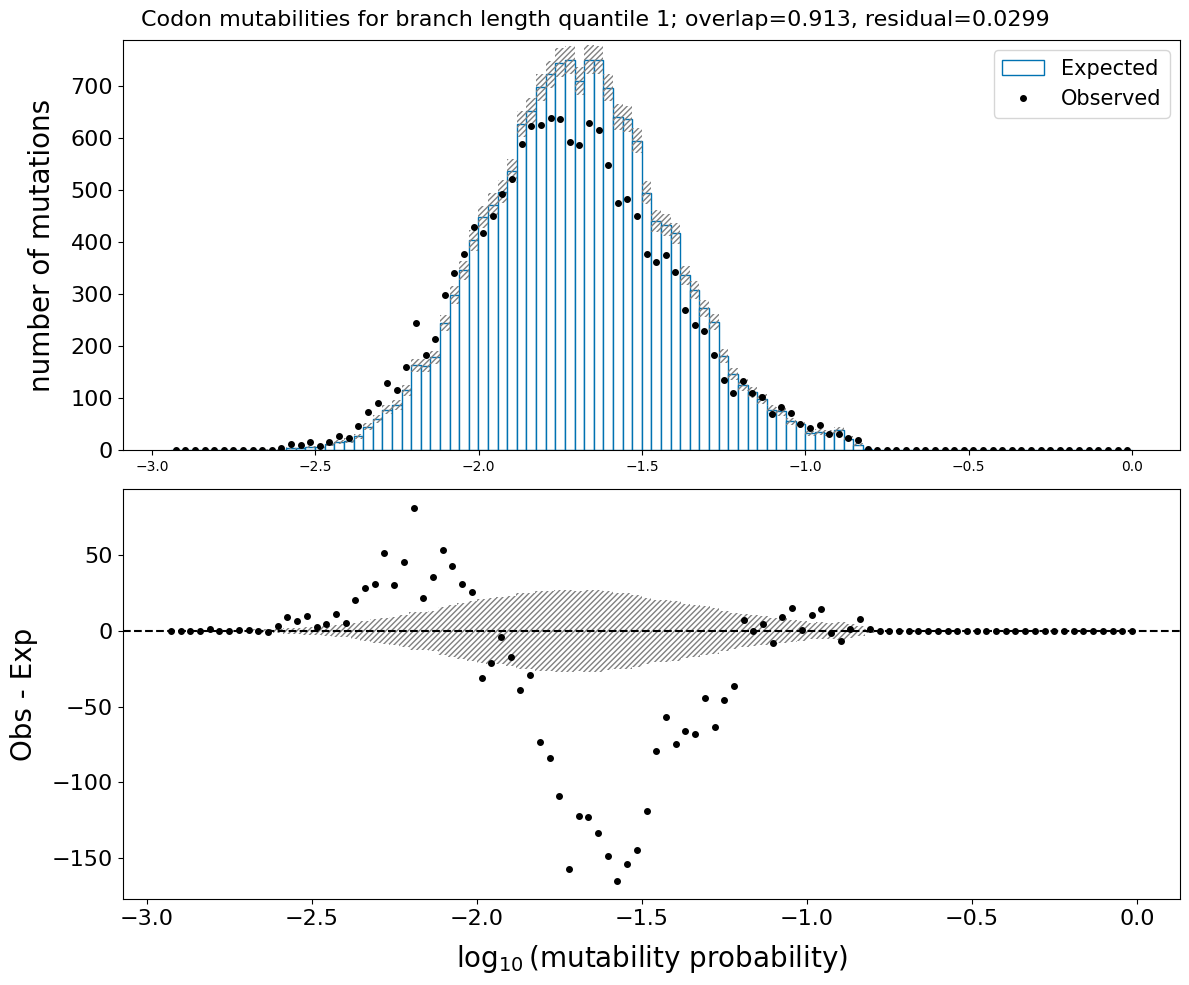

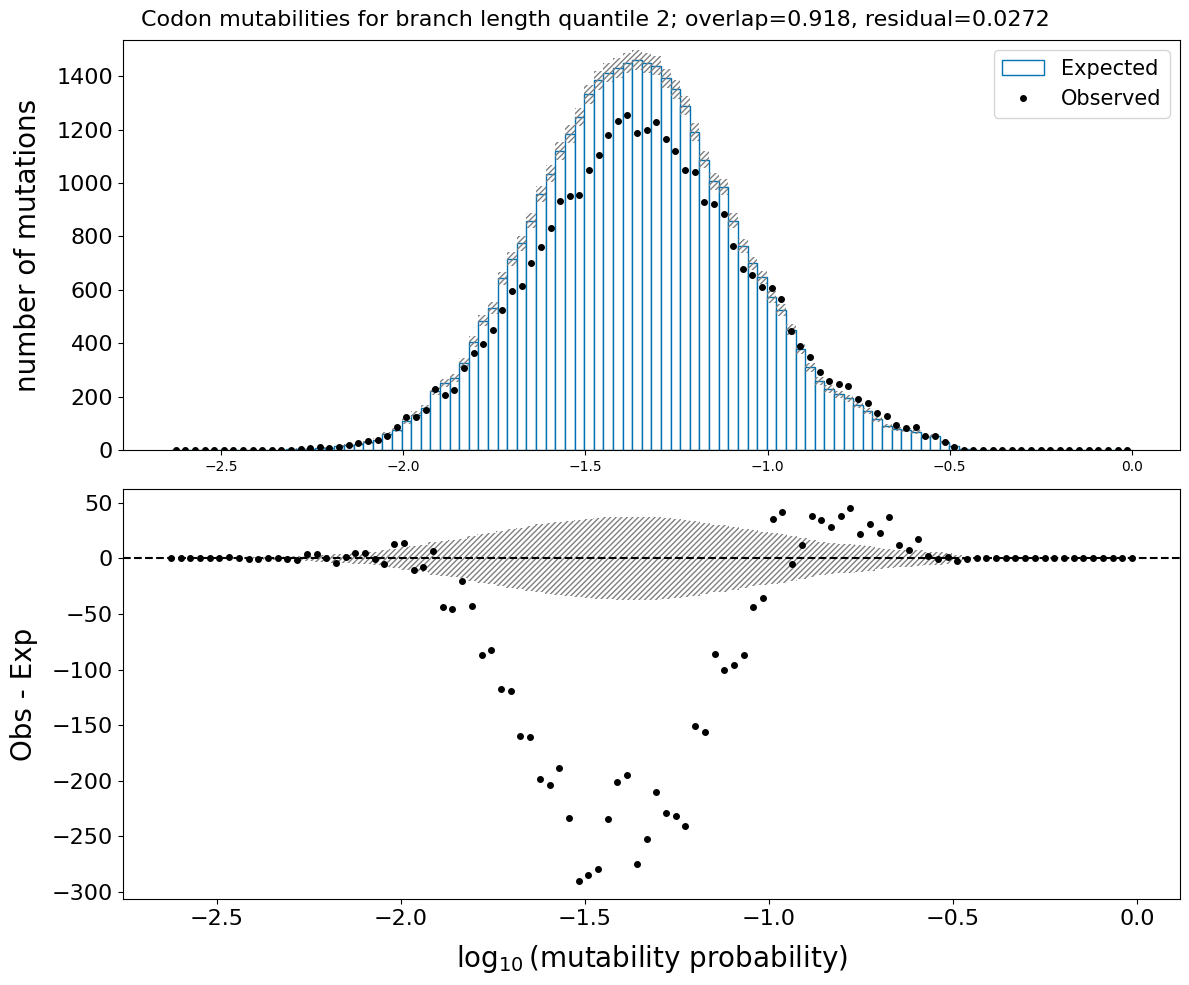

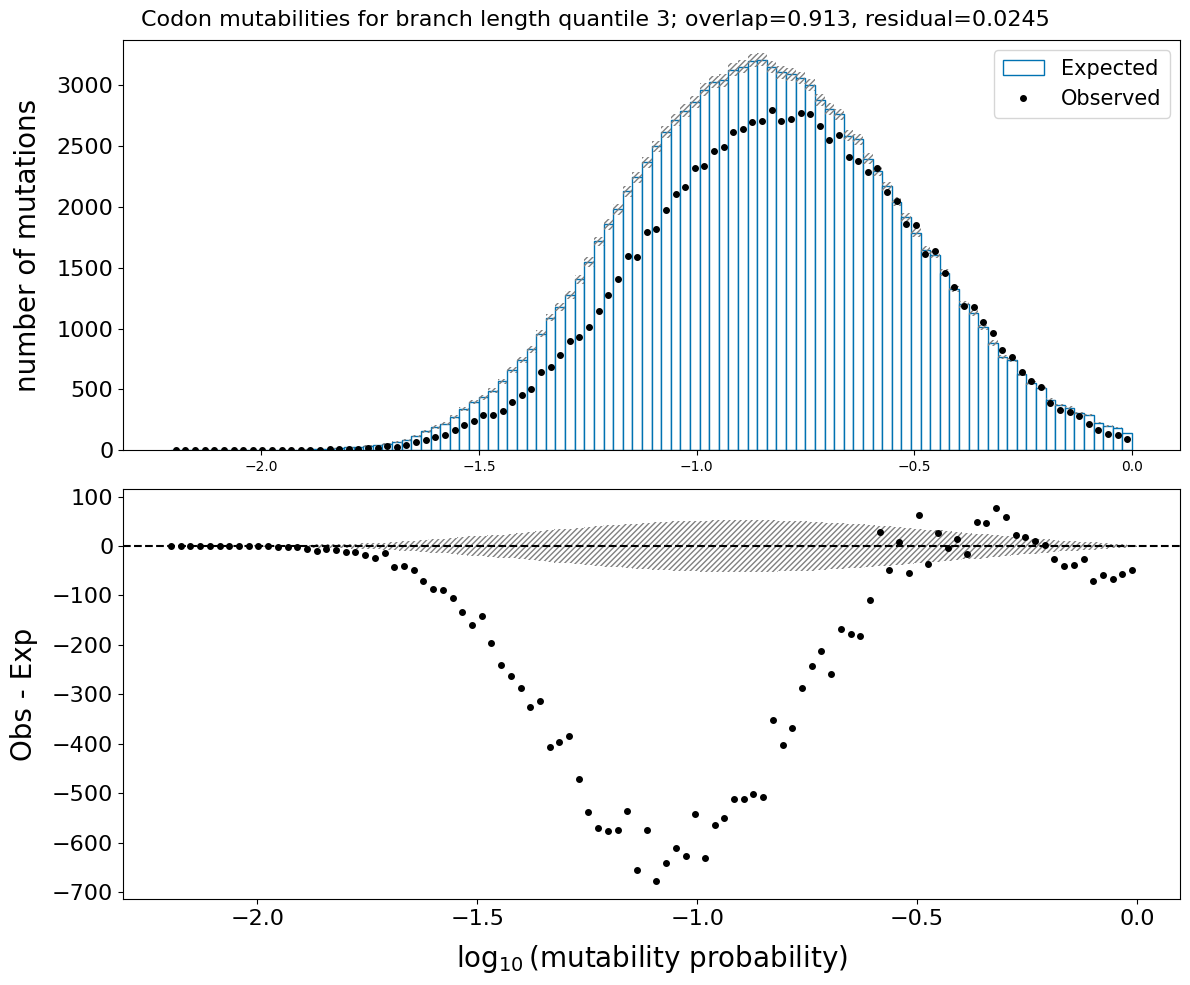

In [ ]:
# loop over a groupby of pcp_df["branch_length_quantile"]
figs = []
results = []
for quantile, group in hc_site_df.groupby("branch_length_quantile"):
    fig, result = simple_codon_oe_plot(group, f"Codon mutabilities for branch length quantile {quantile}")
    figs.append(fig)
    results.append(result)

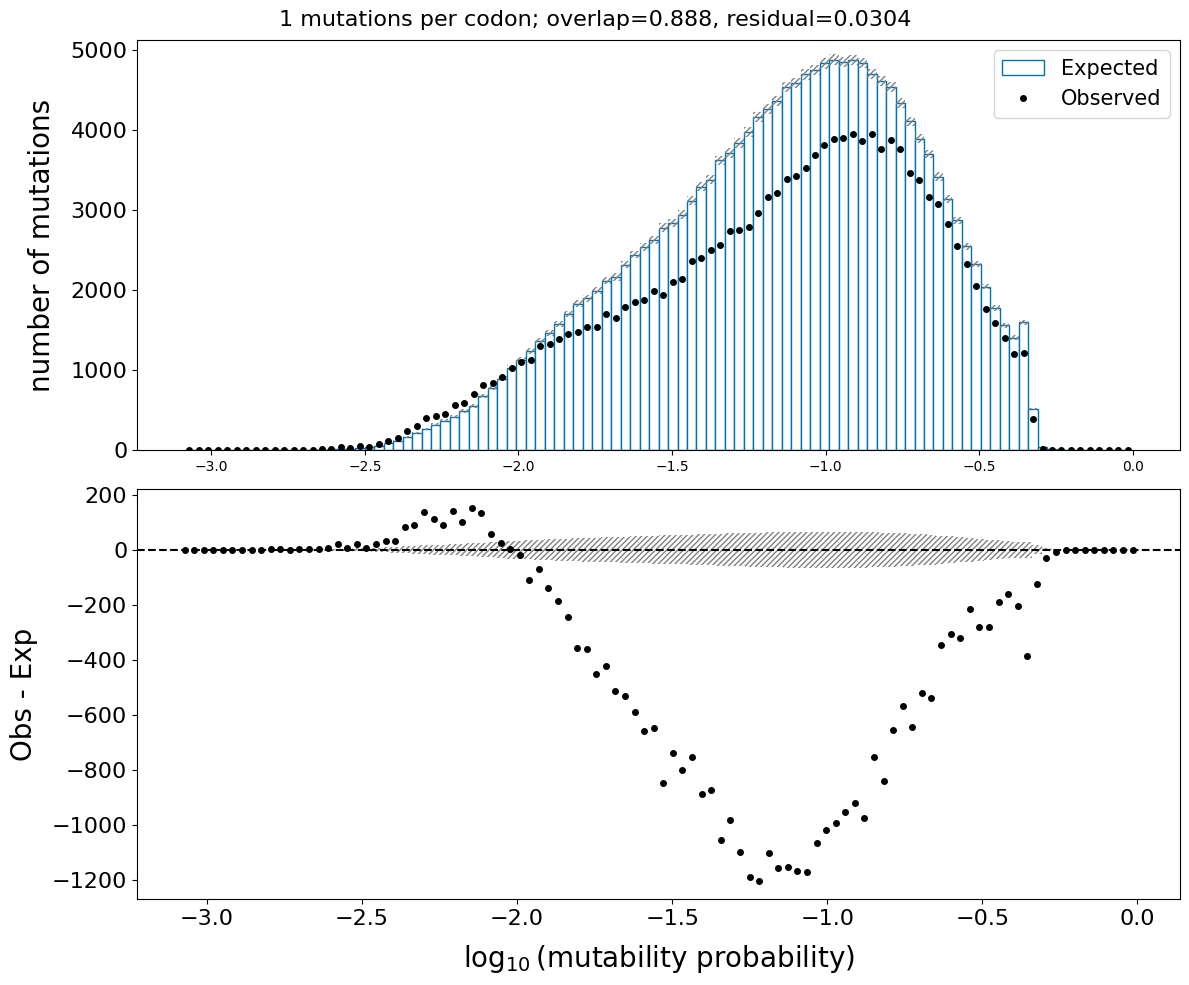

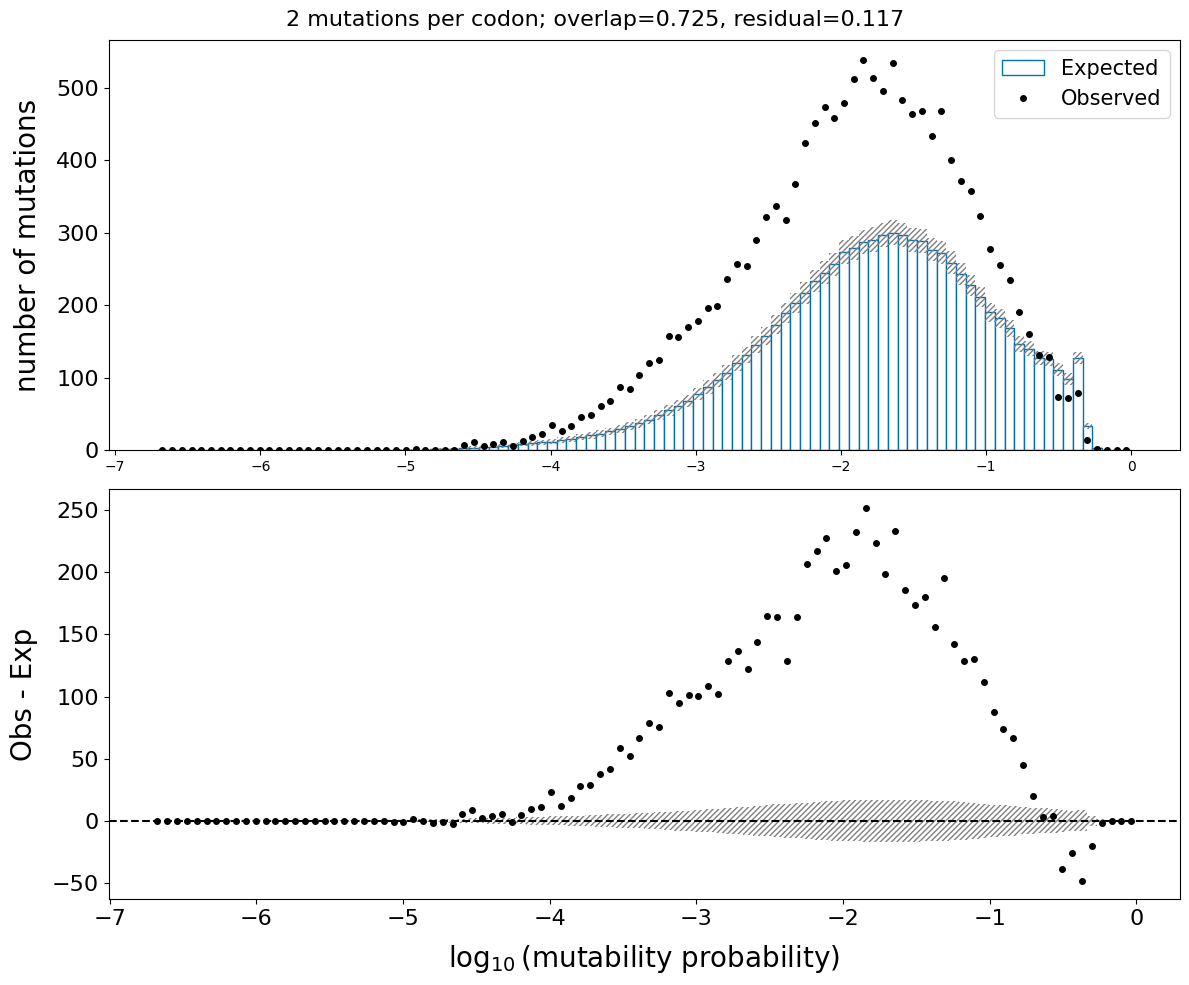

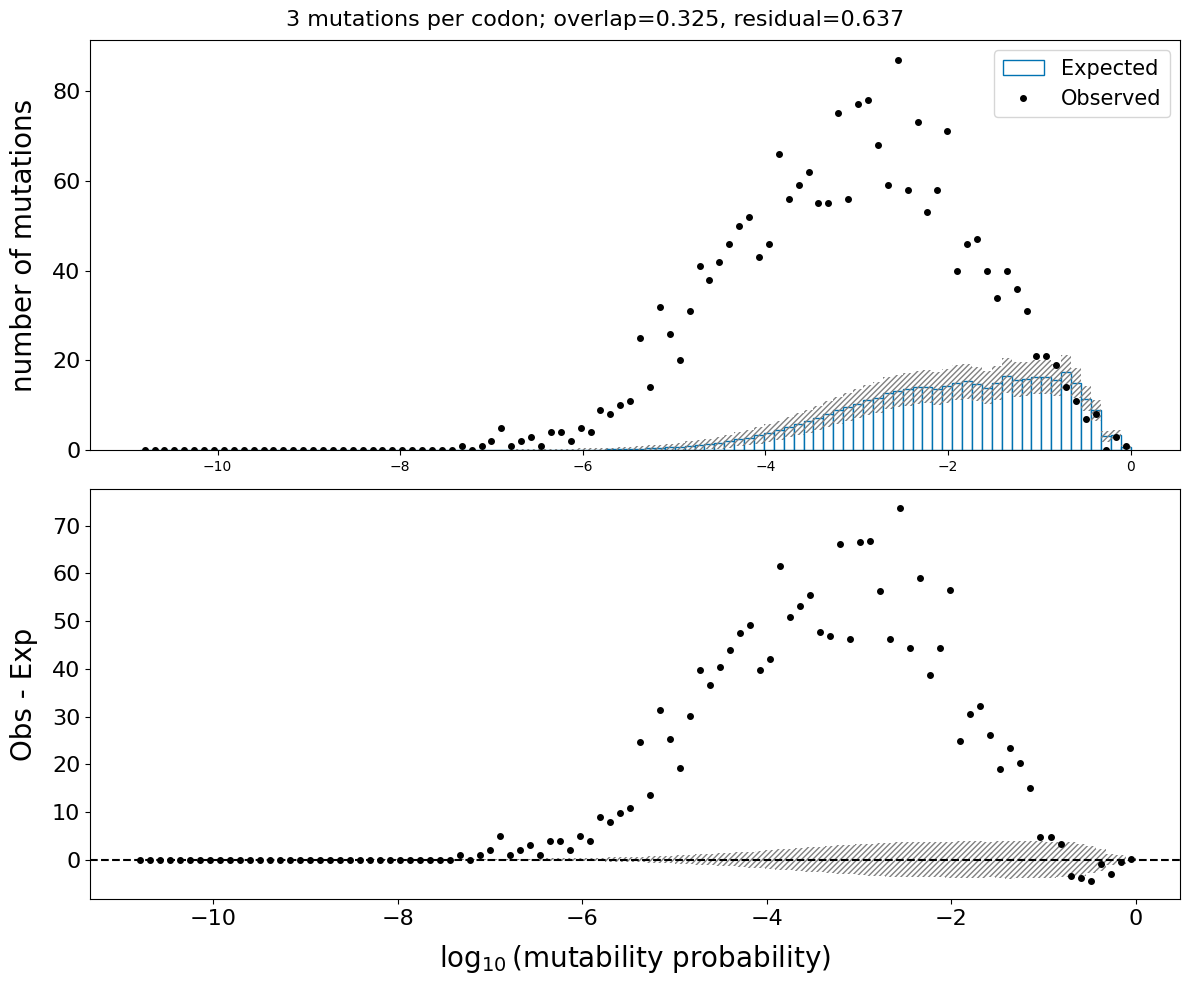

In [ ]:
for hit_class in range(1, 4):
    plot_df = pd.DataFrame({
        "mutation": hc_site_df["hit_class"] == hit_class,
        "prob": hc_site_df[f"{hit_class}_hc_prob"],
    })
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    result_dict = evaluation.plot_observed_vs_expected(plot_df, None, axs[0], axs[1])
    fig.suptitle(f"{hit_class} mutations per codon; overlap={result_dict['overlap']:.3g}, residual={result_dict['residual']:.3g}", fontsize=16)    
    fig.tight_layout()
    fig.savefig(f"_ignore/obs_vs_exp_{hit_class}_mutations_per_codon.png")

### Let's look in detail about probabilities in terms of branch length

In [ ]:
# select rows of pre_obs_vs_exp_df such that hit_class > 1
multihit_df = hc_site_df[hc_site_df["hit_class"] > 1].copy()
multihit_df["nt_site"] = multihit_df["site"] * 3
multihit_df

,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile,nt_site
1348,14,67,2,0.790596,0.193800,0.015229,0.000376,3,201
1363,14,82,2,0.478063,0.416641,0.100128,0.005169,3,246
1645,18,52,2,0.700808,0.265008,0.032856,0.001329,3,156
1661,18,68,2,0.740193,0.236644,0.022536,0.000627,3,204
2717,29,27,2,0.893635,0.102812,0.003515,0.000037,3,81
...,...,...,...,...,...,...,...,...,...
4345317,46373,28,2,0.716486,0.261183,0.021841,0.000489,3,84
4345320,46373,31,3,0.758186,0.220246,0.020917,0.000651,3,93
4345321,46373,32,2,0.846762,0.145160,0.007939,0.000140,3,96
4345323,46373,34,2,0.842446,0.148655,0.008728,0.000171,3,102


In [ ]:
# This block just shows things working for a single parent sequence.

parent, child, rates, subs_probs, branch_length = pcp_df.loc[14, ["parent", "child", "rates", "subs_probs", "branch_length"]]
# truncate each to be a multiple of 3 in length
parent = parent[:len(parent) - len(parent) % 3]
rates = rates[:len(rates) - len(rates) % 3]
subs_probs = subs_probs[:len(subs_probs) - len(subs_probs) % 3]

mask = nt_mask_tensor_of(parent)
parent_idxs = sequences.nt_idx_tensor_of_str(parent.replace("N", "A"))
parent_len = len(parent)
scaled_rates = branch_length * rates[:parent_len]

codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
last_codon_probs = codon_probs[-1]
last_codon_probs

# hit_class_probs_seq(parent, codon_probs, hit_class_tensors)[-6:]

tensor([[[1.8561e-07, 8.9228e-07, 2.6729e-07, 3.7576e-05],
         [3.2419e-05, 1.5584e-04, 4.6684e-05, 6.5628e-03],
         [4.4872e-07, 2.1571e-06, 6.4617e-07, 9.0838e-05],
         [7.6965e-07, 3.6998e-06, 1.1083e-06, 1.5581e-04]],

        [[2.5627e-05, 1.2319e-04, 3.6903e-05, 5.1878e-03],
         [4.4758e-03, 2.1516e-02, 6.4454e-03, 9.0609e-01],
         [6.1951e-05, 2.9781e-04, 8.9213e-05, 1.2541e-02],
         [1.0626e-04, 5.1081e-04, 1.5302e-04, 2.1511e-02]],

        [[1.3177e-07, 6.3344e-07, 1.8976e-07, 2.6676e-05],
         [2.3014e-05, 1.1063e-04, 3.3142e-05, 4.6591e-03],
         [3.1855e-07, 1.5313e-06, 4.5873e-07, 6.4488e-05],
         [5.4639e-07, 2.6266e-06, 7.8682e-07, 1.1061e-04]],

        [[2.2780e-07, 1.0951e-06, 3.2804e-07, 4.6116e-05],
         [3.9787e-05, 1.9126e-04, 5.7295e-05, 8.0544e-03],
         [5.5070e-07, 2.6473e-06, 7.9303e-07, 1.1148e-04],
         [9.4458e-07, 4.5407e-06, 1.3602e-06, 1.9122e-04]]])

In [ ]:
valid_length = (len(parent) // 3) * 3

# Chunk into codons and count mutations
mutations = []
for i in range(0, valid_length, 3):
    parent_codon = parent[i:i+3]
    child_codon = child[i:i+3]
    
    if parent_codon != child_codon:
        mutations.append((i, parent_codon, child_codon, codon_to_idxs[child_codon]))

multihit_sites = set([201, 246])
multihit_mutations = [m for m in mutations if m[0] in multihit_sites]
multihit_mutations, mutations

([(201, 'ACC', 'GAC', (2, 0, 1)), (246, 'AGC', 'AAG', (0, 0, 2))],
 [(123, 'GGG', 'TGG', (3, 2, 2)),
  (132, 'CTG', 'CTA', (1, 3, 0)),
  (165, 'AGC', 'GGC', (2, 2, 1)),
  (186, 'CTC', 'CGC', (1, 2, 1)),
  (198, 'GTC', 'GTA', (2, 3, 0)),
  (201, 'ACC', 'GAC', (2, 0, 1)),
  (204, 'ATA', 'ATG', (0, 3, 2)),
  (210, 'GTA', 'GGA', (2, 2, 0)),
  (219, 'TCC', 'TCG', (3, 1, 2)),
  (225, 'AAC', 'AAT', (0, 0, 3)),
  (231, 'TTC', 'CTC', (1, 3, 1)),
  (246, 'AGC', 'AAG', (0, 0, 2)),
  (249, 'TCT', 'TGT', (3, 2, 3))])

In [ ]:
def mmatch_2(rates):
    """Calculate the moment matching rate for a tensor of two lambda values."""
    inv_rates = 1.0 / rates
    return 1.0 / (inv_rates.sum() - 1.0 / rates.sum())

def mmatch_3(rates):
    """Calculate the moment matching rate for a tensor of three lambda values."""
    inv_rates = 1.0 / rates
    
    # Create a matrix of pairwise sums of rates
    pairwise_sums = rates.unsqueeze(0) + rates.unsqueeze(1)
    
    # Extract the lower triangle part excluding the diagonal to avoid self-pairing
    # and ensure each pair is considered only once
    lower_tri = pairwise_sums.tril(-1)
    
    # Filter out zeros and invert each pairwise sum individually
    nonzero_pairwise_sums = lower_tri[lower_tri != 0]
    inv_nonzero_pairwise_sums = 1.0 / nonzero_pairwise_sums
    
    # Sum the inverted pairwise sums
    sum_inv_pairwise_sums = inv_nonzero_pairwise_sums.sum()

    # Final moment matching calculation for three rates
    return 1.0 / (inv_rates.sum() - sum_inv_pairwise_sums + 1.0 / rates.sum())

mmatch_2(rates[87:89])

tensor(0.6667)

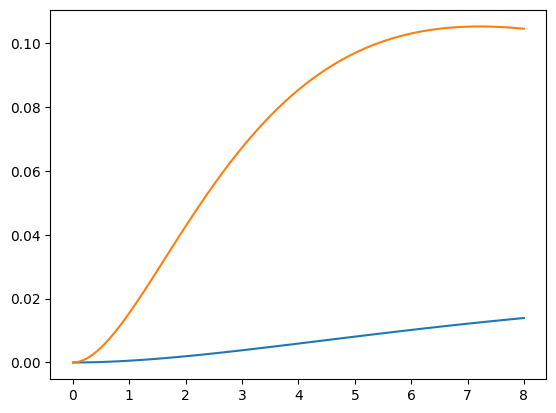

In [ ]:
def probability_of_mutation(branch_length, mutation):
    site, _, _, child_idxs = mutation
    scaled_rates = branch_length * rates[:parent_len]

    codon_probs = codon_probs_of_parent_scaled_rates_and_sub_probs(parent_idxs, scaled_rates, subs_probs)
    site_codon_probs = codon_probs[site//3]
    return site_codon_probs[child_idxs]

# make a plot of probability_of_mutation for each mutation, where branch length ranges from branch_length/2 to 2*branch_length in 100 steps
fig, ax = plt.subplots()
x_values = np.linspace(0.001, 8, 100)

for mutation in multihit_mutations:
    site, _, _, child_idxs = mutation
    probs = [probability_of_mutation(branch_length * factor, mutation) for factor in x_values]
    ax.plot(x_values, probs, label=site)

In [ ]:
mmatch_2(0.1*torch.Tensor([1.1764, 1.1049]))

tensor(0.0759)

### Simulated data

In [ ]:
sim_df = pd.read_csv("~/data/mimic_shmoof_CNNJoiLrgShmoofSmall.10K.csv.gz", compression="gzip", index_col=0)
sim_df = prepare_pcp_df(sim_df)

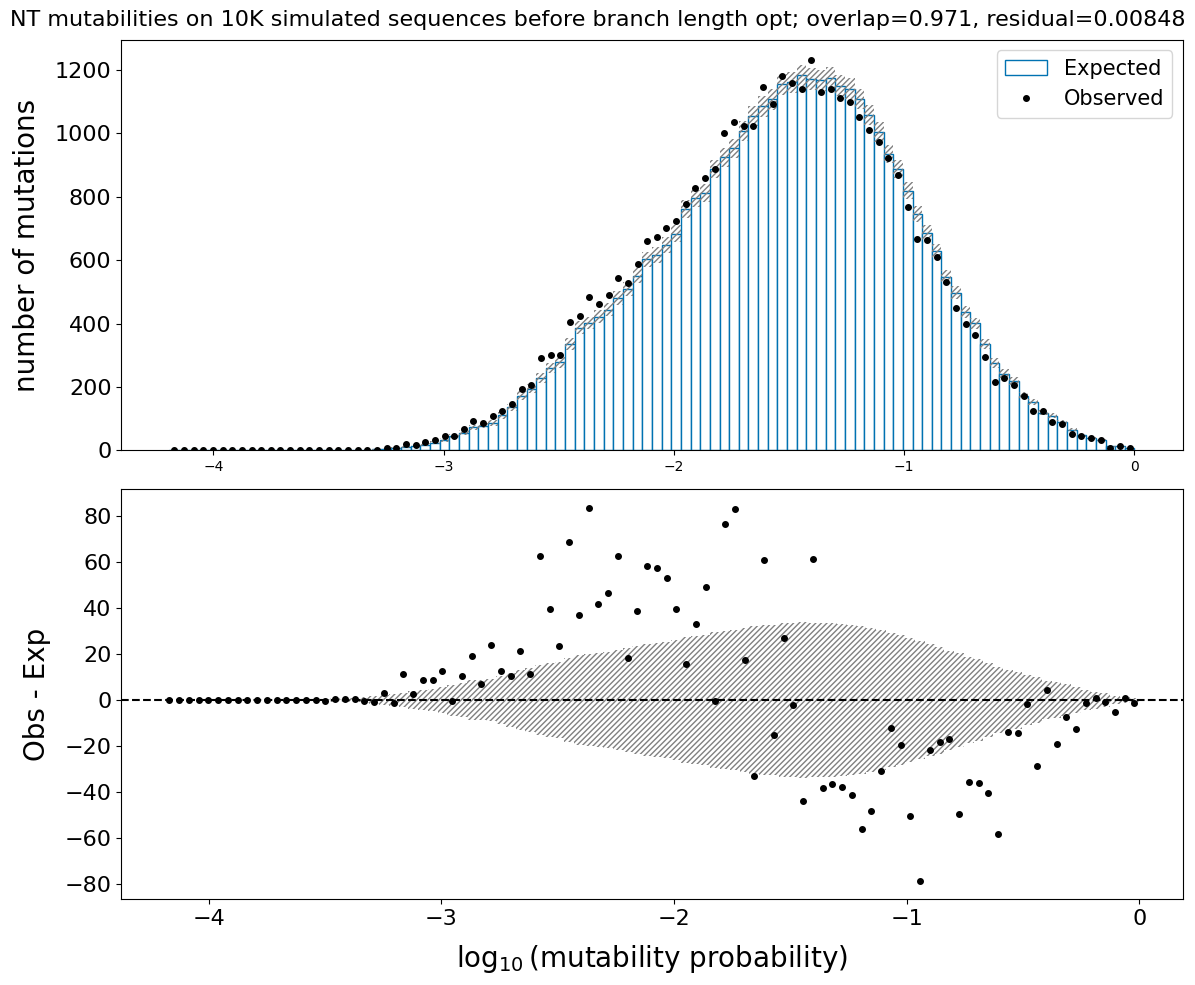

In [ ]:
nt_level_oe_plot_of_pcp_df(sim_df, "NT mutabilities on 10K simulated sequences before branch length opt")

Finding optimal branch lengths: 100%|██████████| 9998/9998 [00:31<00:00, 320.56it/s]


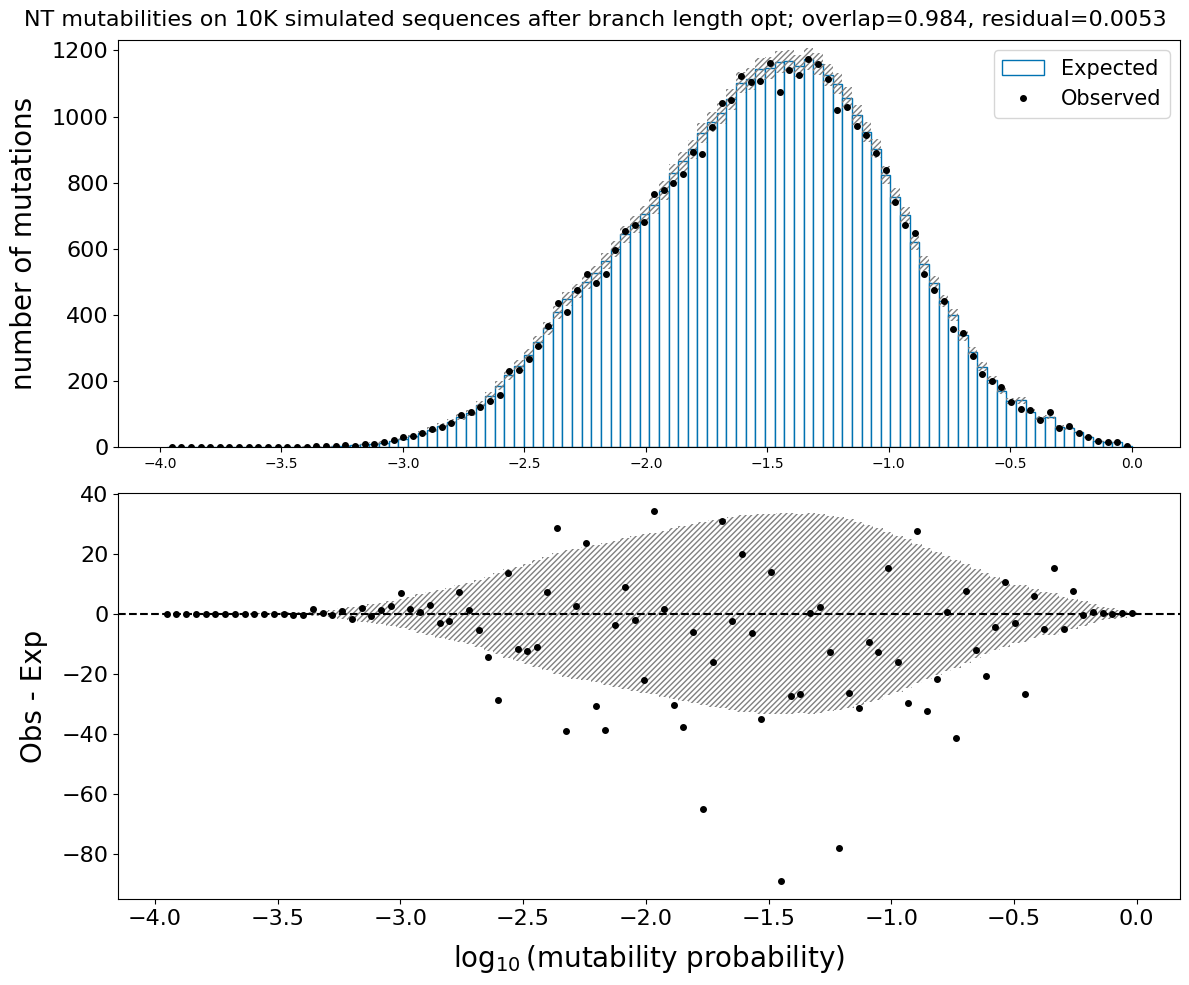

In [ ]:
sim_df = optimize_site_indep_branch_length(sim_df)
nt_level_oe_plot_of_pcp_df(sim_df, "NT mutabilities on 10K simulated sequences after branch length opt")

In [ ]:
sim_hc_site_df = hc_site_df_of_pcp_df(sim_df, hit_class_tensors)
sim_hc_site_df

Consolidating rows: 100%|██████████| 9998/9998 [00:04<00:00, 2017.06it/s]


,sequence,site,hit_class,0_hc_prob,1_hc_prob,2_hc_prob,3_hc_prob,branch_length_quantile
0,0,22,0,0.988751,0.011220,0.000030,2.088760e-08,2
1,0,23,0,0.994102,0.005888,0.000010,4.855306e-09,2
2,0,24,0,0.993202,0.006784,0.000014,8.997491e-09,2
3,0,25,0,0.985049,0.014879,0.000072,1.115585e-07,2
4,0,26,0,0.987393,0.012557,0.000050,5.917910e-08,2
...,...,...,...,...,...,...,...,...
935083,9997,113,0,0.952598,0.046677,0.000721,3.560431e-06,2
935084,9997,114,0,0.963529,0.036065,0.000405,1.405258e-06,2
935085,9997,115,0,0.949986,0.049199,0.000811,4.190927e-06,2
935086,9997,116,0,0.970541,0.029167,0.000291,9.658621e-07,2


(<Figure size 1200x1000 with 2 Axes>,
 {'overlap': 0.9859896467746555,
  'residual': 0.0042954063618810545,
  'counts_twinx_ax': None})

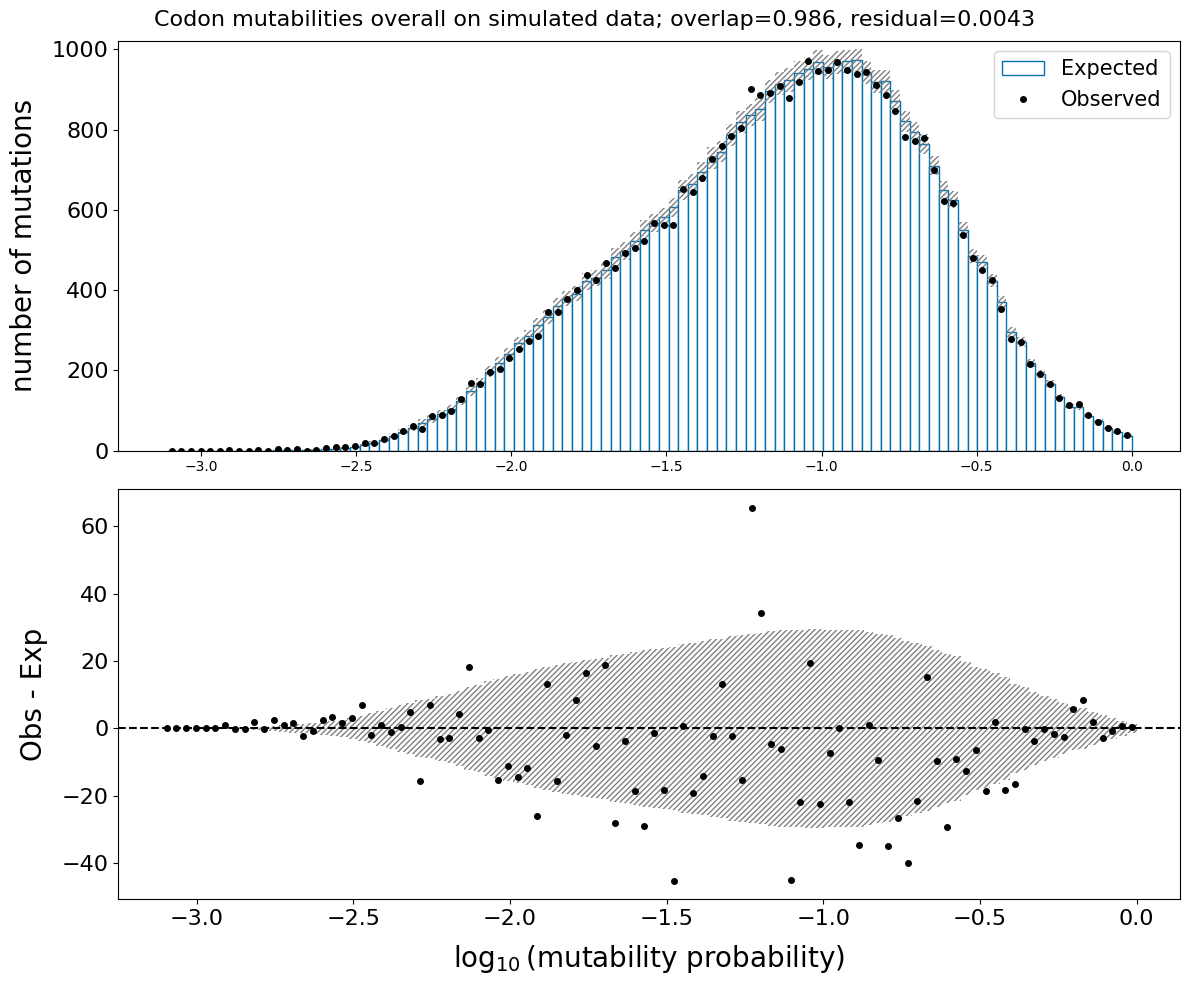

In [ ]:
simple_codon_oe_plot(sim_hc_site_df, "Codon mutabilities overall on simulated data")